In [4]:
# Install necessary packages if needed
# !pip install scanpy matplotlib seaborn pandas numpy anndata

# Import libraries
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set plotting settings
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, frameon=False)

BASE_DIR = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Linda_RNA"

# 1. Setup and Data Loading

In [6]:
# Path to the matrix files
CELL_DATA_DIR = "cells_data"
SAMPLE = "R26_Nestin_Mut_adult"
matrix_dir = os.path.join(BASE_DIR, CELL_DATA_DIR, SAMPLE)

# Load the data from the filtered matrix
adata = sc.read_10x_mtx(
    matrix_dir,
    var_names='gene_symbols',
    cache=True
)

# Basic information
print(f"Shape of loaded data: {adata.shape}")  # cells × genes

... writing an h5ad cache file to speedup reading next time
Shape of loaded data: (410, 33696)


# 2. Basic Pre-processing

filtered out 16664 genes that are detected in less than 3 cells


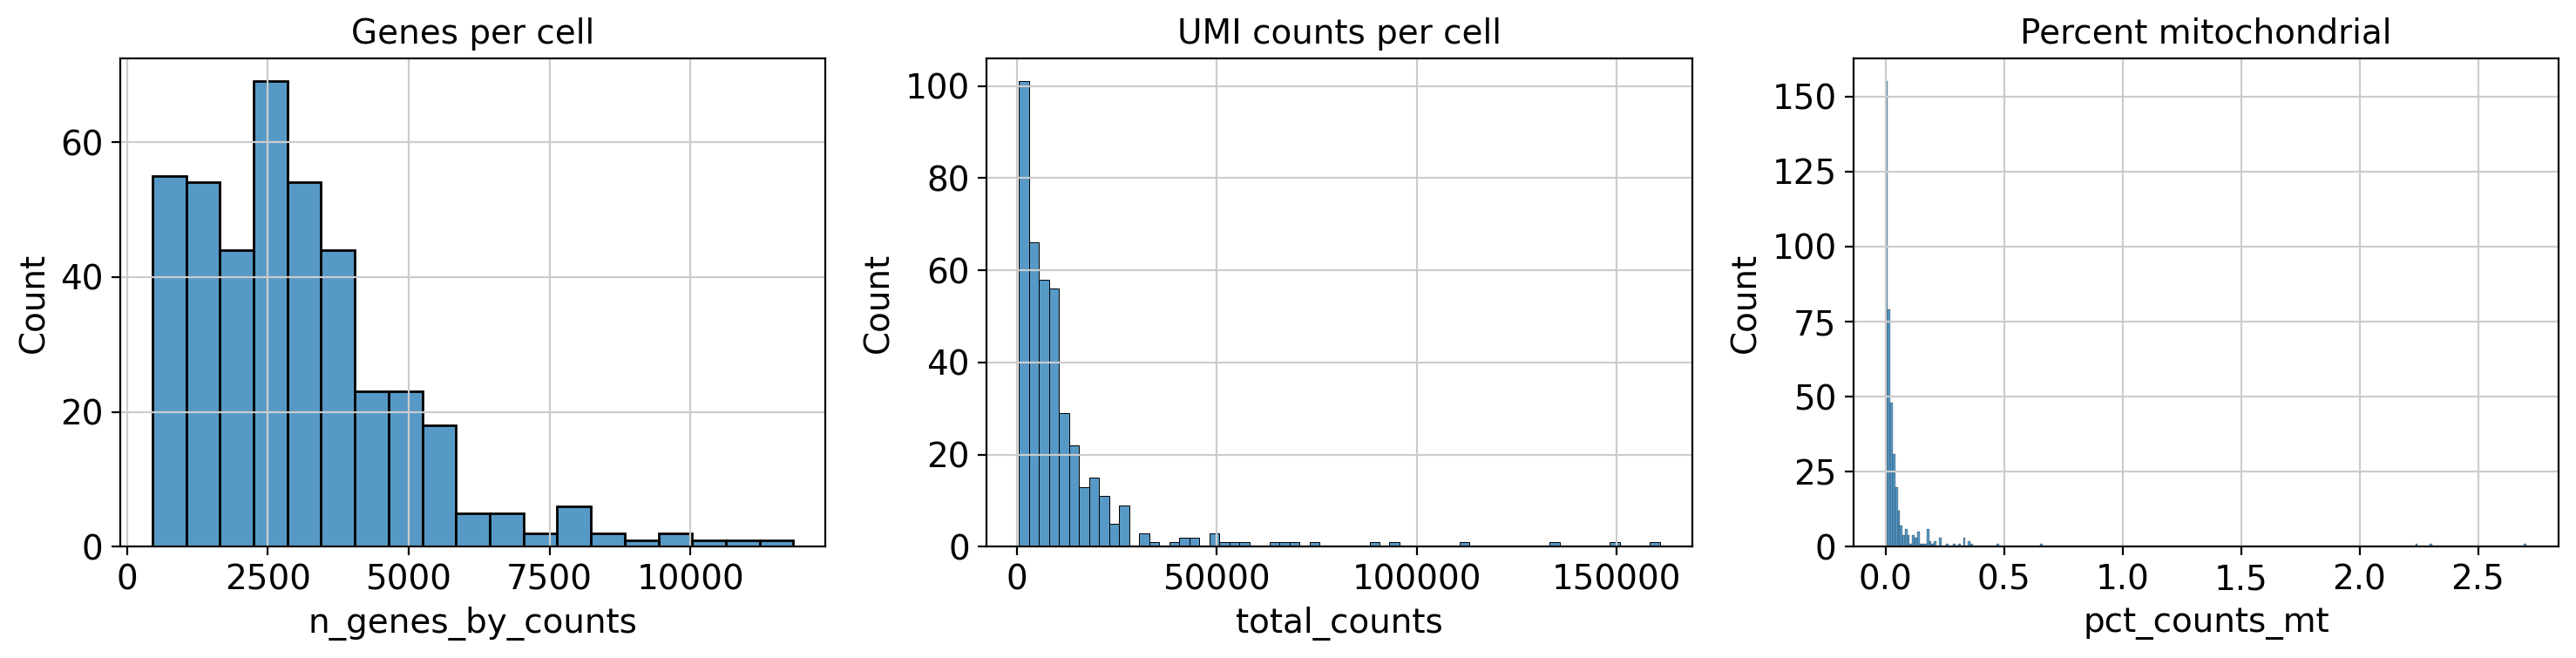

In [7]:
# Make a copy of the raw counts
adata.raw = adata.copy()

# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Calculate QC metrics
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # identify mitochondrial genes
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Plot QC metrics
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(adata.obs['n_genes_by_counts'], kde=False, ax=axs[0])
axs[0].set_title('Genes per cell')
sns.histplot(adata.obs['total_counts'], kde=False, ax=axs[1])
axs[1].set_title('UMI counts per cell')
sns.histplot(adata.obs['pct_counts_mt'], kde=False, ax=axs[2])
axs[2].set_title('Percent mitochondrial')
plt.tight_layout()
plt.show()

# 3. Filtering Based on QC Metrics

In [8]:
# Filter out cells with too many/few genes or high mitochondrial content
max_genes = 6000  # Adjust based on your QC plot
min_genes = 500   # Adjust based on your QC plot
max_mt_pct = 20   # Adjust based on your QC plot

adata = adata[adata.obs['n_genes_by_counts'] < max_genes, :]
adata = adata[adata.obs['n_genes_by_counts'] > min_genes, :]
adata = adata[adata.obs['pct_counts_mt'] < max_mt_pct, :]

print(f"Number of cells after filtering: {adata.n_obs}")
print(f"Number of genes after filtering: {adata.n_vars}")

Number of cells after filtering: 381
Number of genes after filtering: 17032


# 4. Normalization and Log Transformation

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/beegfs/scratch/ric.broccoli/kubacki.michal/conda_envs/snakemake/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:208: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Number of highly variable genes: 4886


<Figure size 1000x800 with 0 Axes>

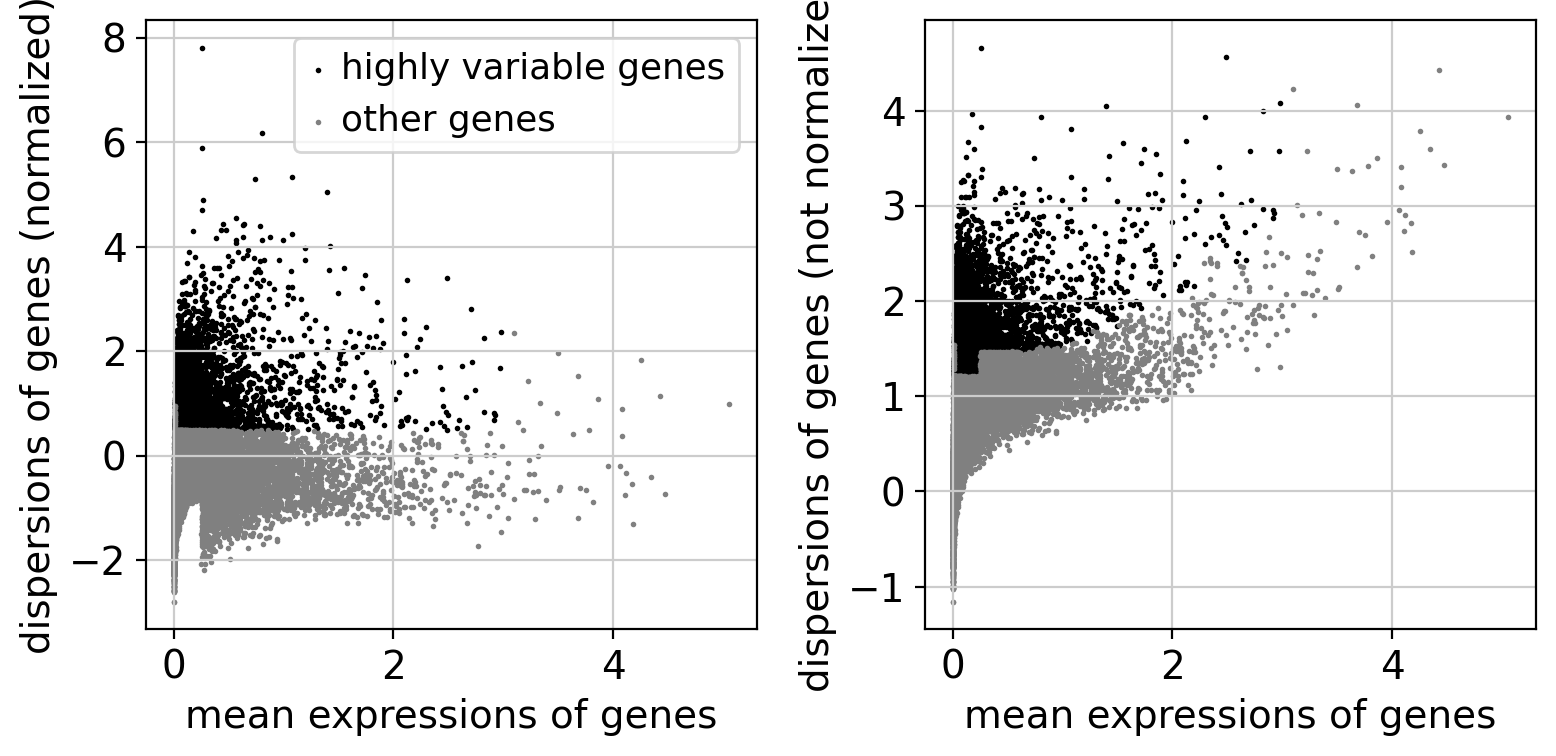

In [9]:
# Normalize to 10,000 reads per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# Log transform
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
print(f"Number of highly variable genes: {sum(adata.var.highly_variable)}")

# Plot highly variable genes
plt.figure(figsize=(10, 8))
sc.pl.highly_variable_genes(adata, show=False)
plt.tight_layout()
plt.show()

# Keep only highly variable genes for dimensionality reduction
adata_hvg = adata[:, adata.var.highly_variable]

# 5. Dimensionality Reduction

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/beegfs/scratch/ric.broccoli/kubacki.michal/conda_envs/snakemake/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA
    with n_comps=50
    finished (0:00:03)


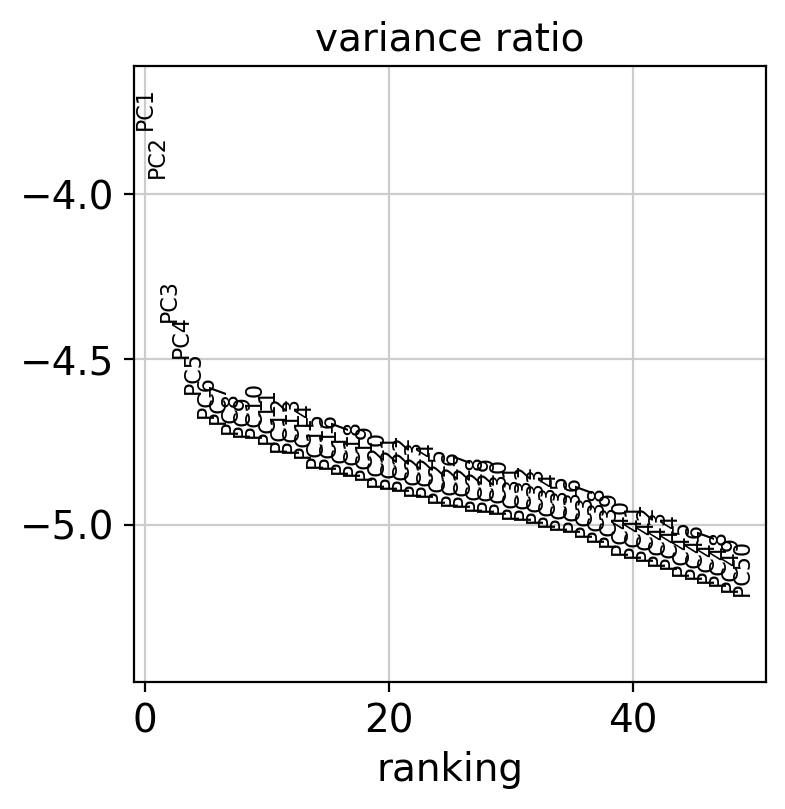

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:01)


/tmp/ipykernel_102925/3709656582.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x800 with 0 Axes>

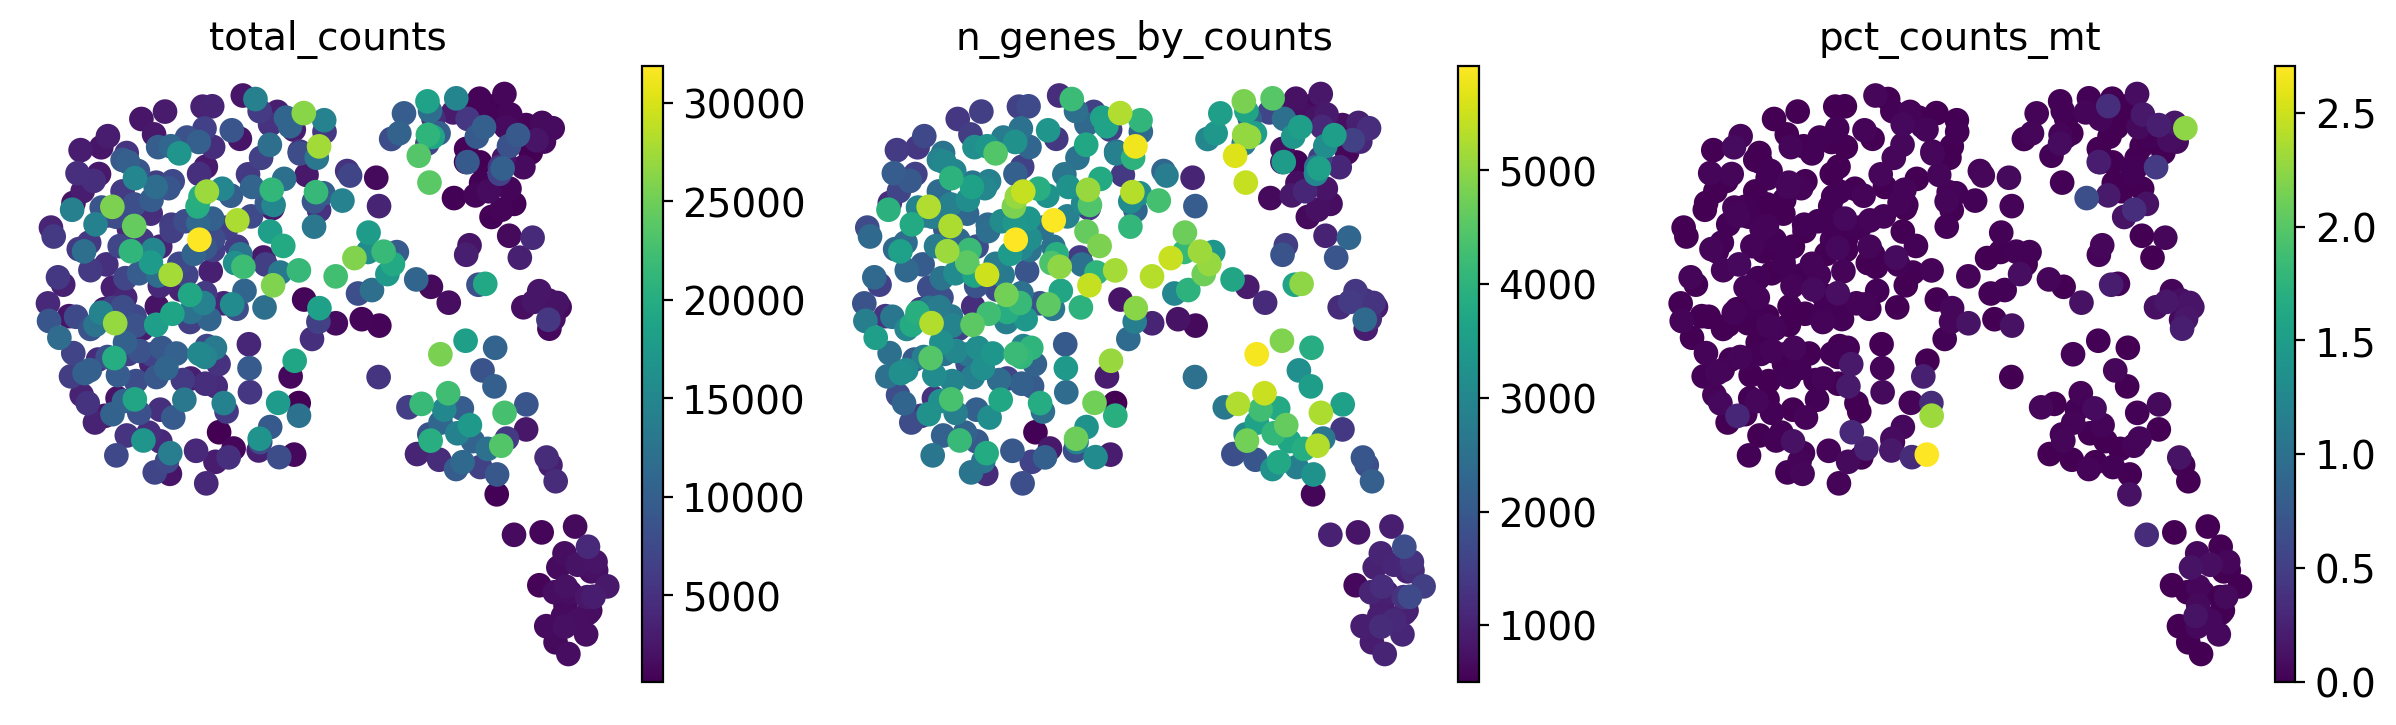

In [10]:
# Scale data to unit variance and zero mean
sc.pp.scale(adata_hvg, max_value=10)

# Run PCA
sc.tl.pca(adata_hvg, svd_solver='arpack')

# Determine number of significant PCs
sc.pl.pca_variance_ratio(adata_hvg, n_pcs=50, log=True)
plt.show()

# Choose number of PCs for downstream analyses
n_pcs = 30  # Adjust based on the variance ratio plot

# Compute neighborhood graph
sc.pp.neighbors(adata_hvg, n_neighbors=15, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(adata_hvg)

# Plot UMAP
plt.figure(figsize=(10, 8))
sc.pl.umap(adata_hvg, color=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], 
           use_raw=False, color_map='viridis', show=False)
plt.tight_layout()
plt.show()

# 6. Clustering

running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/tmp/ipykernel_102925/937930628.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_hvg, resolution=0.5)  # Adjust resolution as needed


<Figure size 1000x800 with 0 Axes>

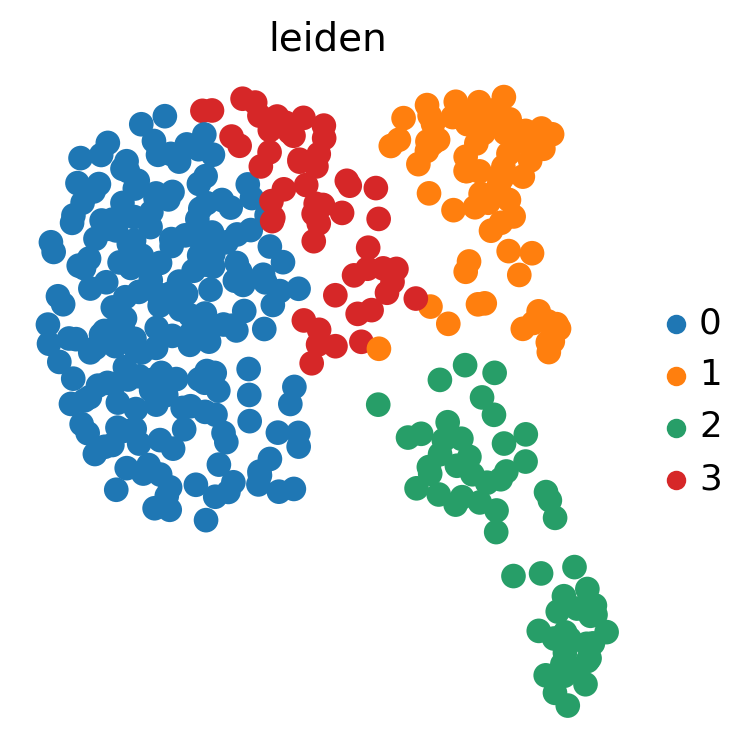

leiden
0    199
1     69
2     60
3     53
Name: count, dtype: int64
running Leiden clustering
    finished: found 2 clusters and added
    'leiden_res0.1', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden_res0.3', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_res0.7', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res1.0', the cluster labels (adata.obs, categorical) (0:00:00)


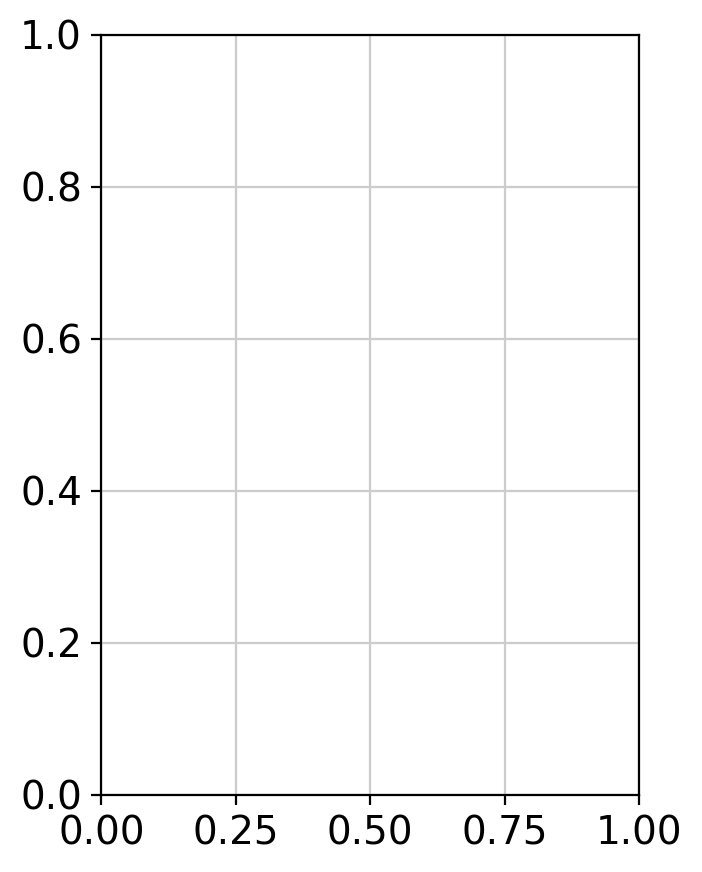

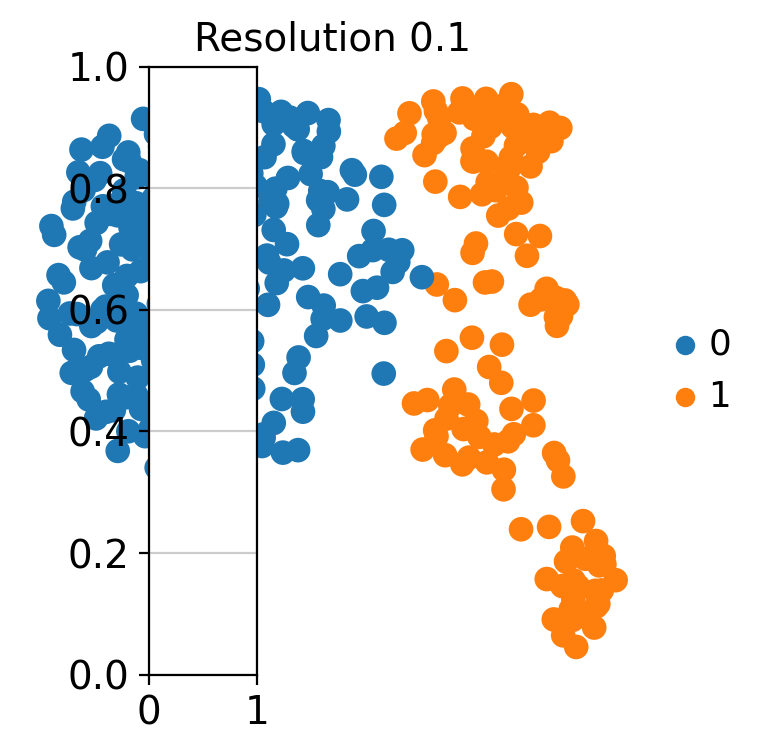

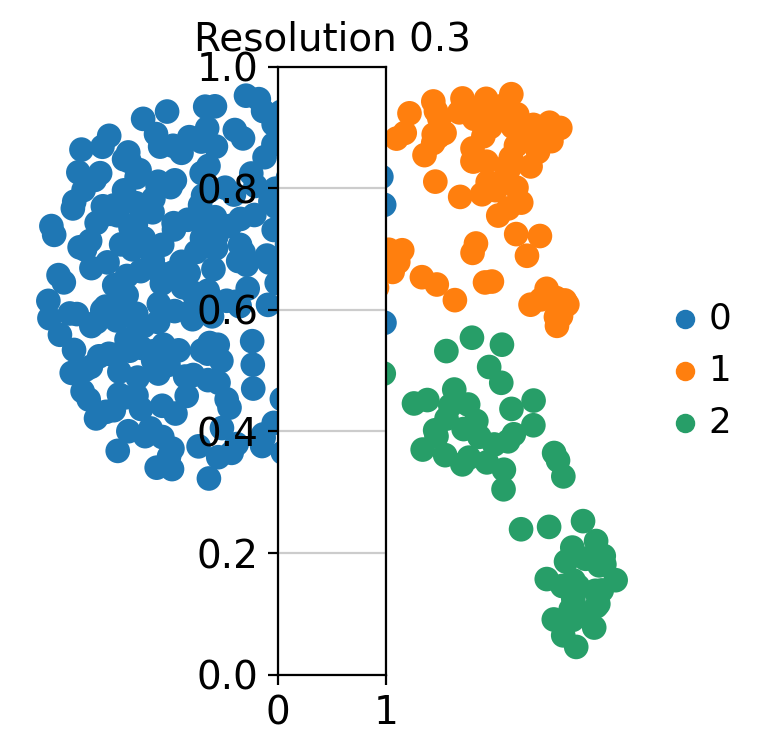

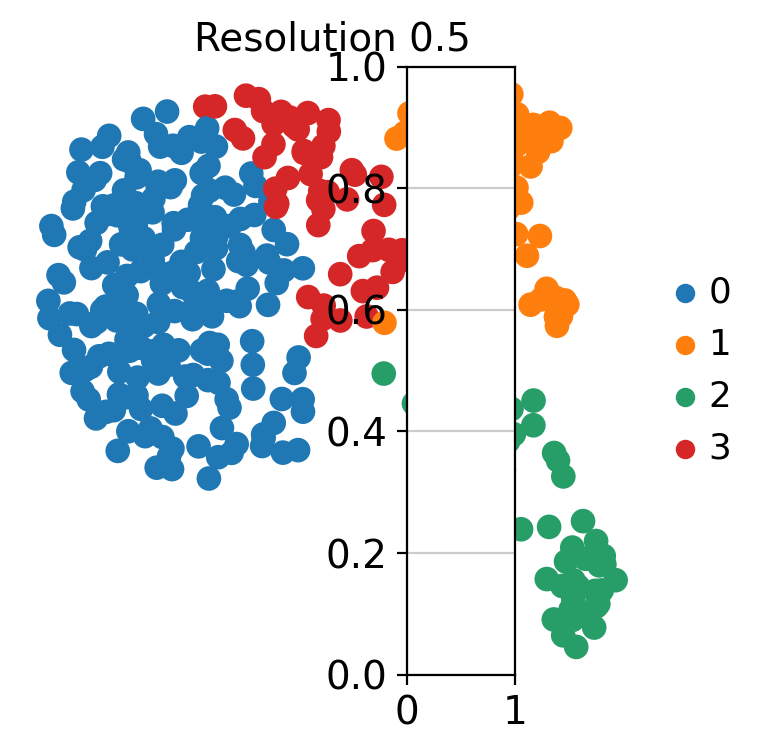

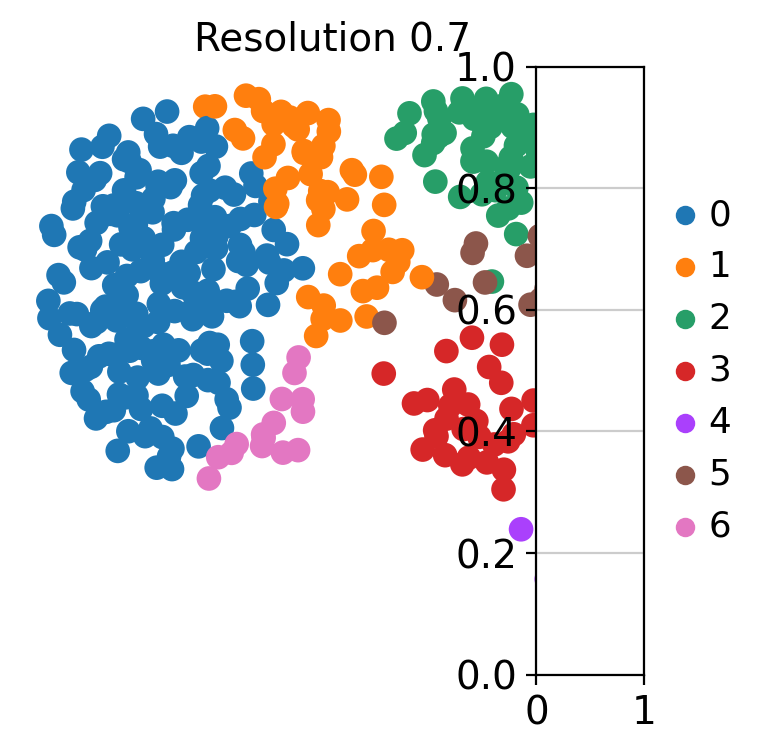

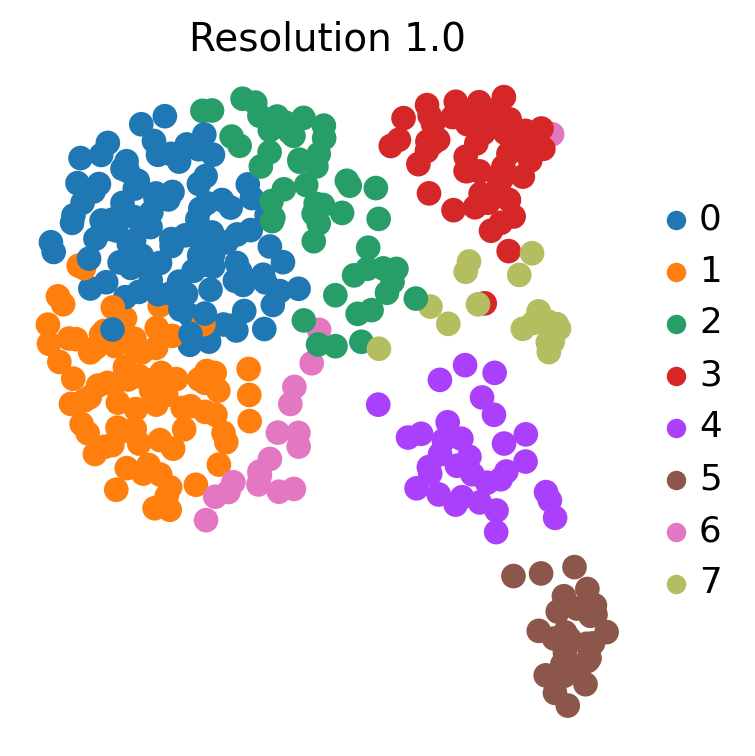

In [13]:
# Find clusters using Leiden algorithm
sc.tl.leiden(adata_hvg, resolution=0.5)  # Adjust resolution as needed

# Plot clusters on UMAP
plt.figure(figsize=(10, 8))
sc.pl.umap(adata_hvg, color='leiden', show=False)
plt.tight_layout()
plt.show()

# Check cluster sizes
cluster_counts = adata_hvg.obs['leiden'].value_counts()
print(cluster_counts)

# Try different resolutions to find optimal number of clusters
resolutions = [0.1, 0.3, 0.5, 0.7, 1.0]
for res in resolutions:
    sc.tl.leiden(adata_hvg, resolution=res, key_added=f'leiden_res{res}')

# Plot clusters at different resolutions
plt.figure(figsize=(20, 5))
for i, res in enumerate(resolutions):
    plt.subplot(1, len(resolutions), i+1)
    sc.pl.umap(adata_hvg, color=f'leiden_res{res}', title=f'Resolution {res}', show=False)
plt.tight_layout()
plt.show()

# 7. Marker Gene Identification

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


/tmp/ipykernel_102925/2602645545.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1500x1000 with 0 Axes>

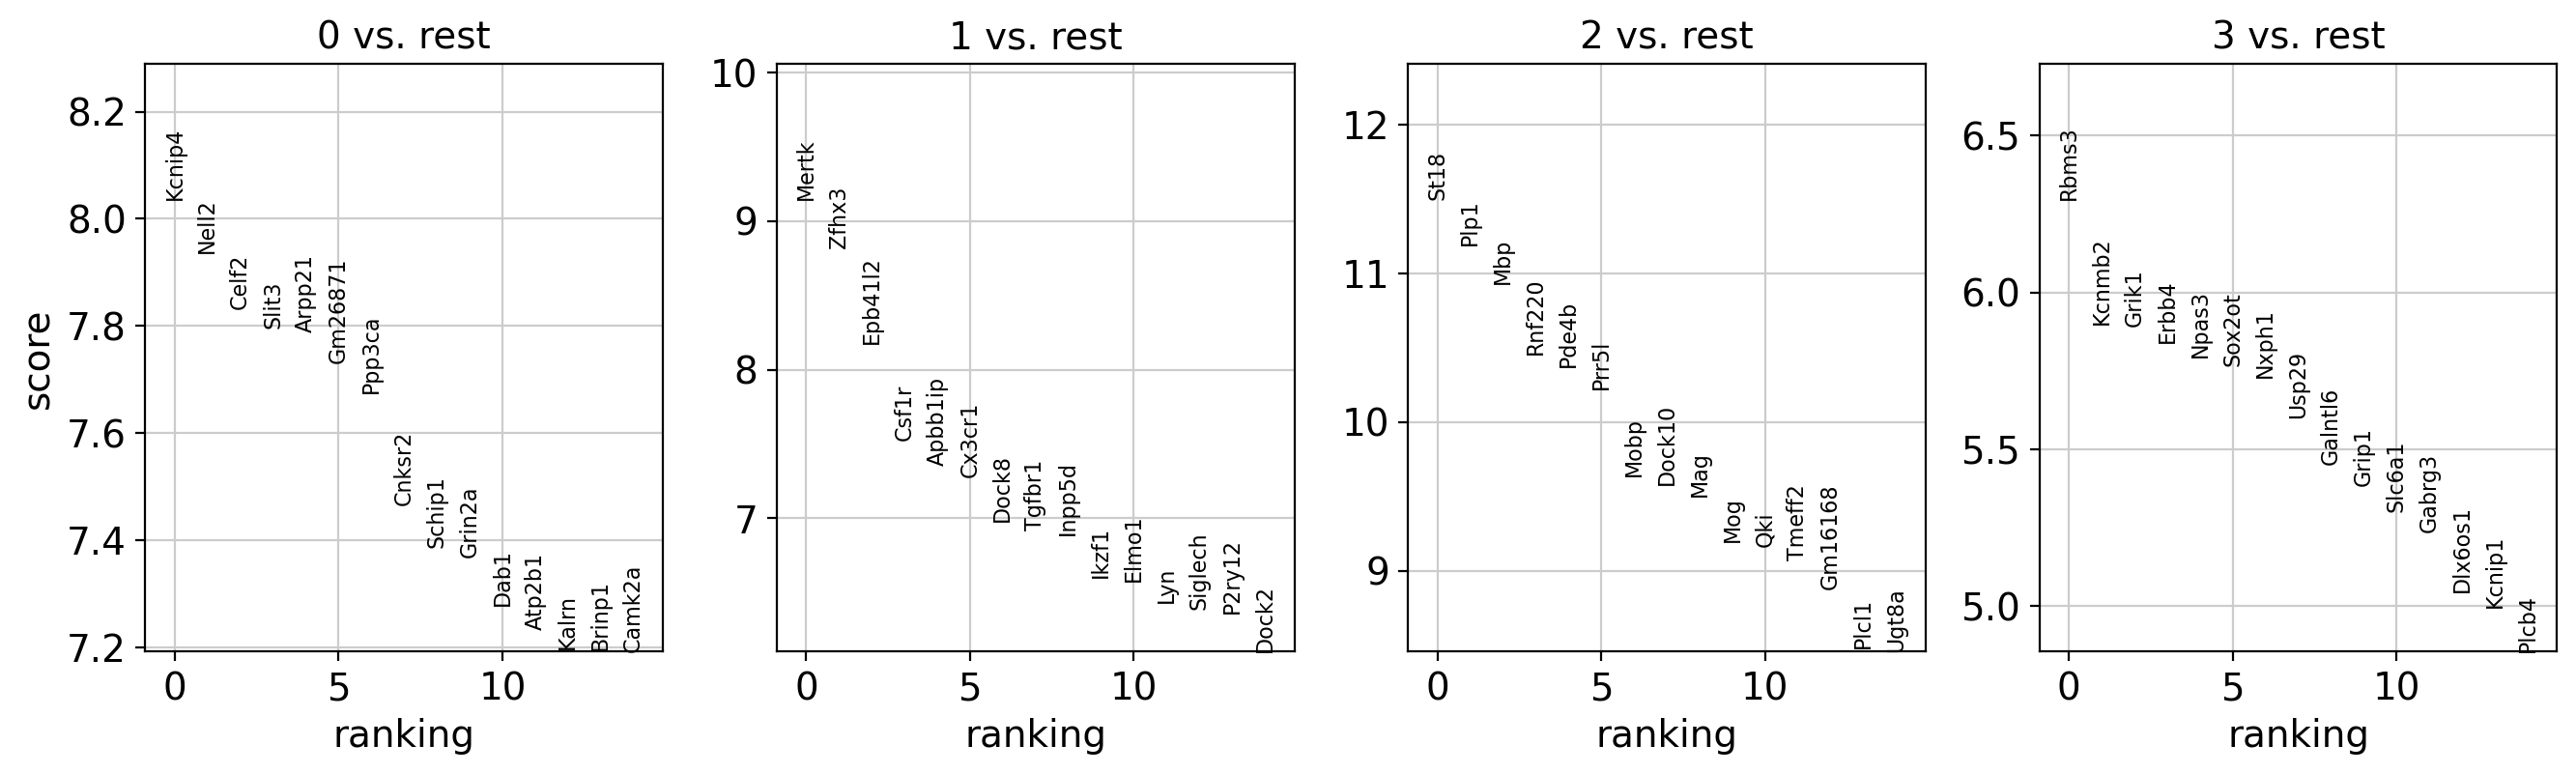

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


/tmp/ipykernel_102925/2602645545.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1500x1000 with 0 Axes>

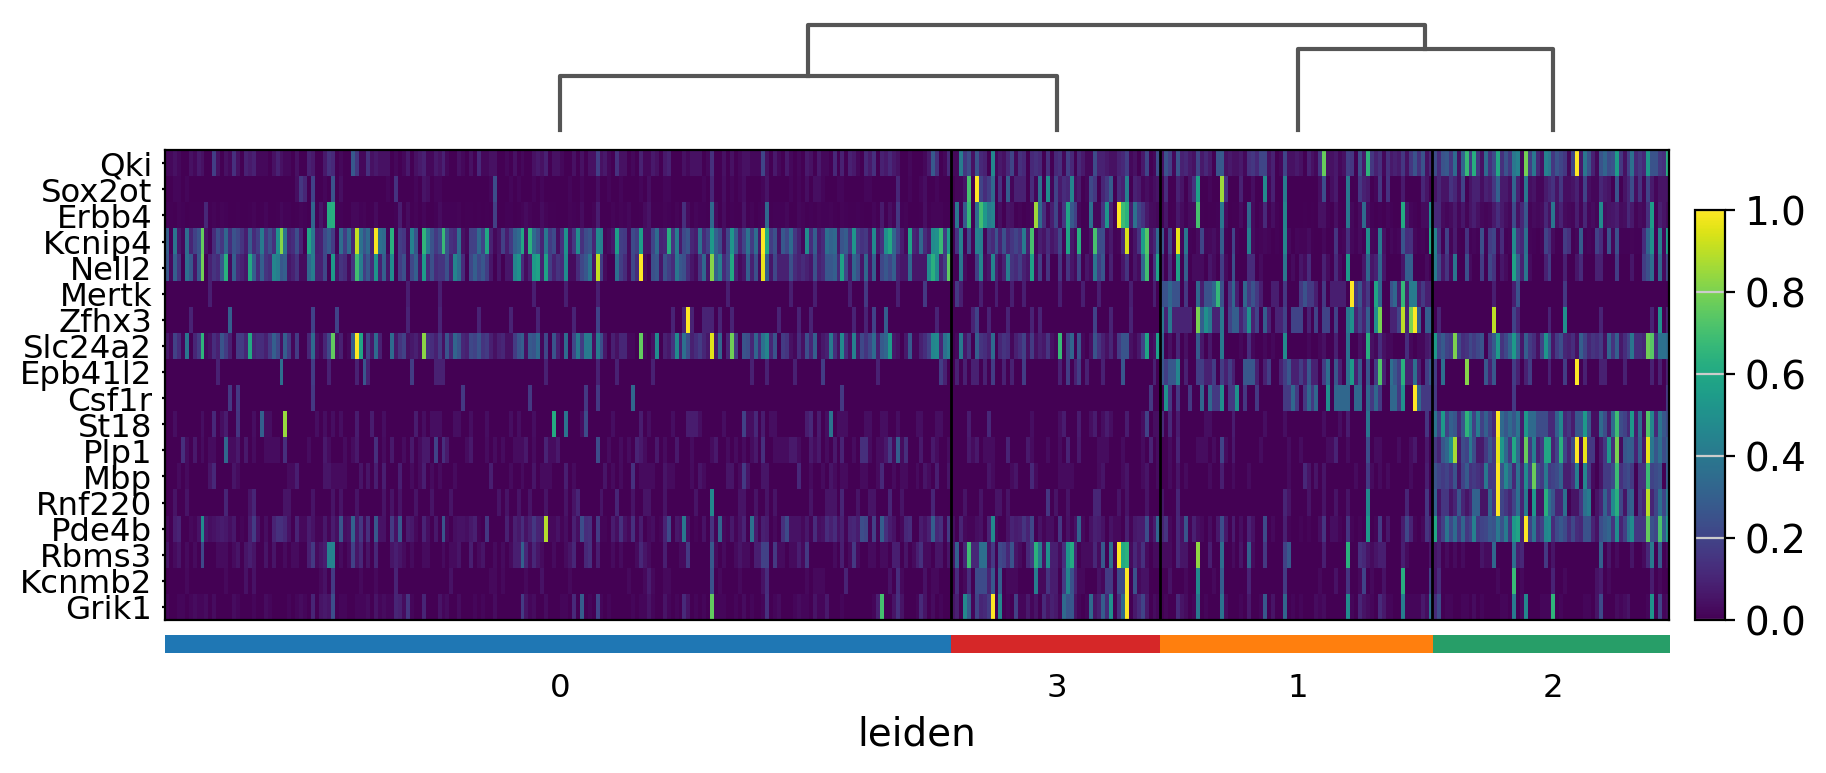

In [14]:
# Find marker genes for each cluster
sc.tl.rank_genes_groups(adata_hvg, 'leiden', method='wilcoxon')

# Plot top marker genes
plt.figure(figsize=(15, 10))
sc.pl.rank_genes_groups(adata_hvg, n_genes=15, sharey=False, show=False)
plt.tight_layout()
plt.show()

# Get the top markers for each cluster
marker_genes = pd.DataFrame()
for i in range(len(np.unique(adata_hvg.obs['leiden']))):
    markers = sc.get.rank_genes_groups_df(adata_hvg, group=str(i))
    markers = markers.sort_values('pvals_adj')
    markers['cluster'] = i
    marker_genes = pd.concat([marker_genes, markers.head(10)])

# Save markers to CSV
marker_genes.to_csv('cluster_markers.csv', index=False)

# Heatmap of top markers per cluster
top_markers_per_cluster = {}
for cluster in np.unique(adata_hvg.obs['leiden']):
    cluster_markers = marker_genes[marker_genes['cluster'] == int(cluster)]
    top_markers_per_cluster[cluster] = cluster_markers['names'].tolist()[:5]

markers_flat = [gene for cluster_markers in top_markers_per_cluster.values() for gene in cluster_markers]
markers_unique = list(dict.fromkeys(markers_flat))  # Remove duplicates while preserving order

plt.figure(figsize=(15, 10))
sc.pl.heatmap(adata_hvg, markers_unique, groupby='leiden', dendrogram=True, 
              swap_axes=True, use_raw=True, show=False, standard_scale='var')
plt.tight_layout()
plt.show()

# 8. Cell Type Annotation

<Figure size 1200x1000 with 0 Axes>

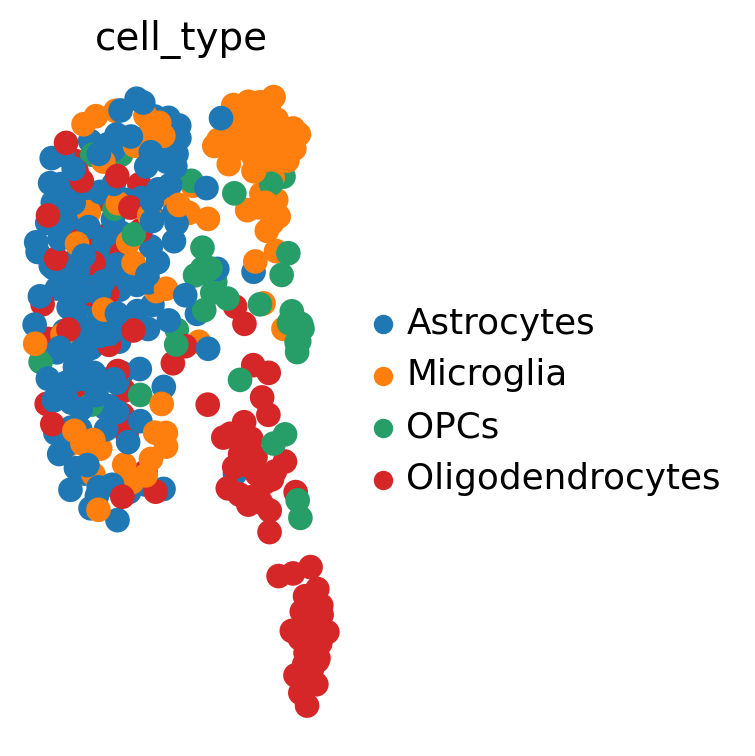

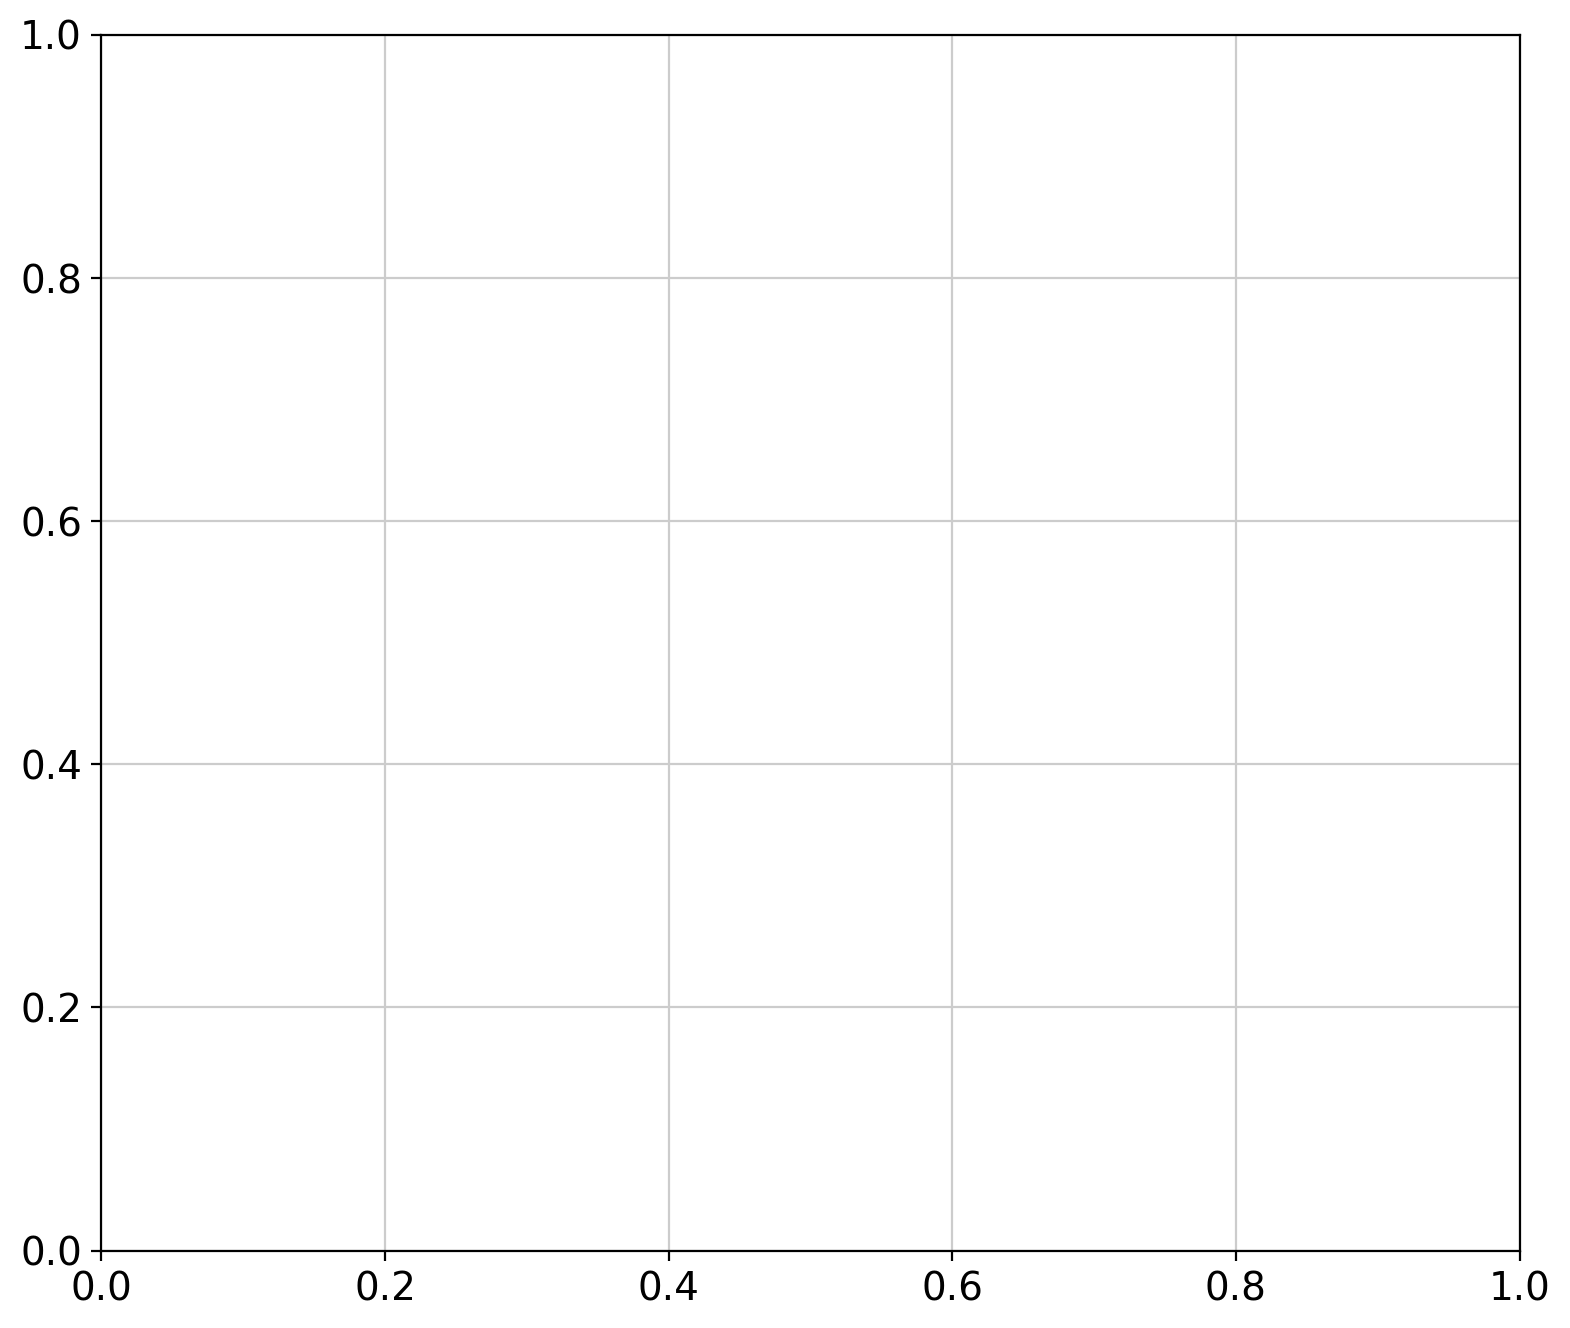

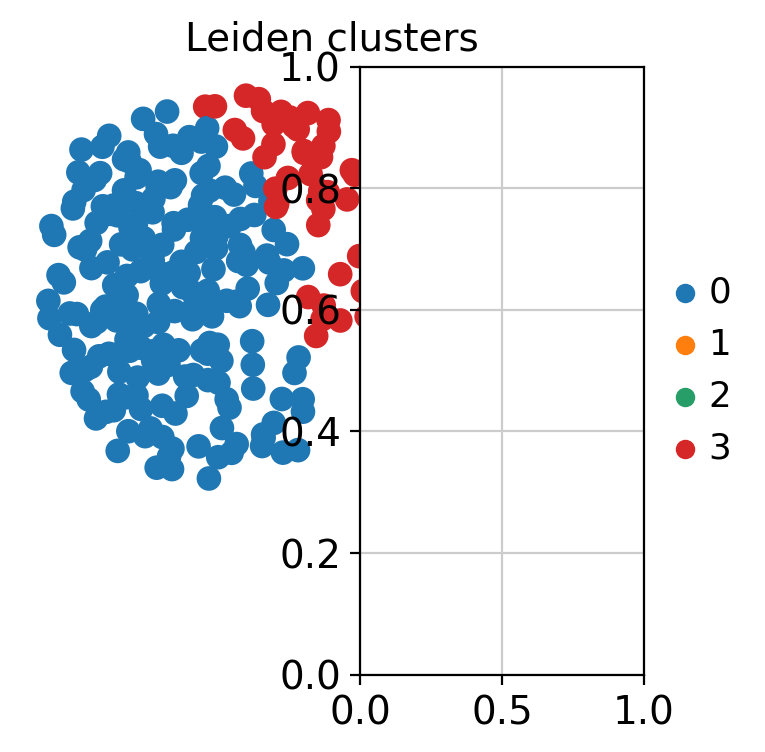

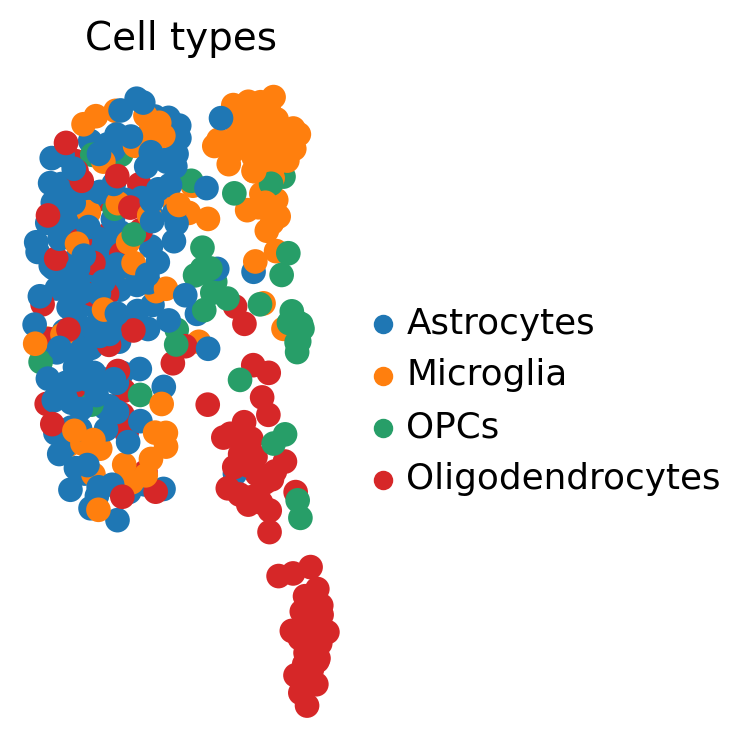

In [15]:
# Example of a basic function to annotate cell types based on known markers
def annotate_cell_types(adata):
    # Define known markers for cell types (adjust based on your organism/tissue)
    cell_type_markers = {
        'Neurons': ['Rbfox3', 'Tubb3', 'Map2', 'Snap25'],
        'Astrocytes': ['Gfap', 'Aqp4', 'Aldh1l1'],
        'Oligodendrocytes': ['Mbp', 'Plp1', 'Mog', 'Olig1', 'Olig2'],
        'Microglia': ['Cx3cr1', 'P2ry12', 'Hexb', 'Csf1r'],
        'OPCs': ['Pdgfra', 'Cspg4'],
        'Endothelial': ['Cldn5', 'Pecam1', 'Vwf'],
        'Pericytes': ['Pdgfrb', 'Rgs5', 'Acta2']
    }
    
    # Create a new dataframe to store scores
    cell_type_scores = pd.DataFrame(index=adata.obs_names)
    
    # For each cell type, calculate the mean expression of marker genes
    for cell_type, markers in cell_type_markers.items():
        # Find markers that exist in the dataset
        existing_markers = [marker for marker in markers if marker in adata.var_names]
        if len(existing_markers) > 0:
            # Calculate mean expression of markers for each cell
            cell_type_scores[cell_type] = adata[:, existing_markers].X.mean(axis=1)
    
    # Assign cell type based on highest score
    adata.obs['cell_type'] = cell_type_scores.idxmax(axis=1)
    
    # Add score for visualization
    adata.obs['cell_type_score'] = cell_type_scores.max(axis=1)
    
    return adata

# Annotate cell types
adata_hvg = annotate_cell_types(adata_hvg)

# Plot cell types on UMAP
plt.figure(figsize=(12, 10))
sc.pl.umap(adata_hvg, color='cell_type', show=False)
plt.tight_layout()
plt.show()

# Compare with Leiden clusters
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sc.pl.umap(adata_hvg, color='leiden', title='Leiden clusters', show=False)
plt.subplot(1, 2, 2)
sc.pl.umap(adata_hvg, color='cell_type', title='Cell types', show=False)
plt.tight_layout()
plt.show()

# 9. Differential Expression Analysis

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/beegfs/scratch/ric.broccoli/kubacki.michal/conda_envs/snakemake/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1331: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


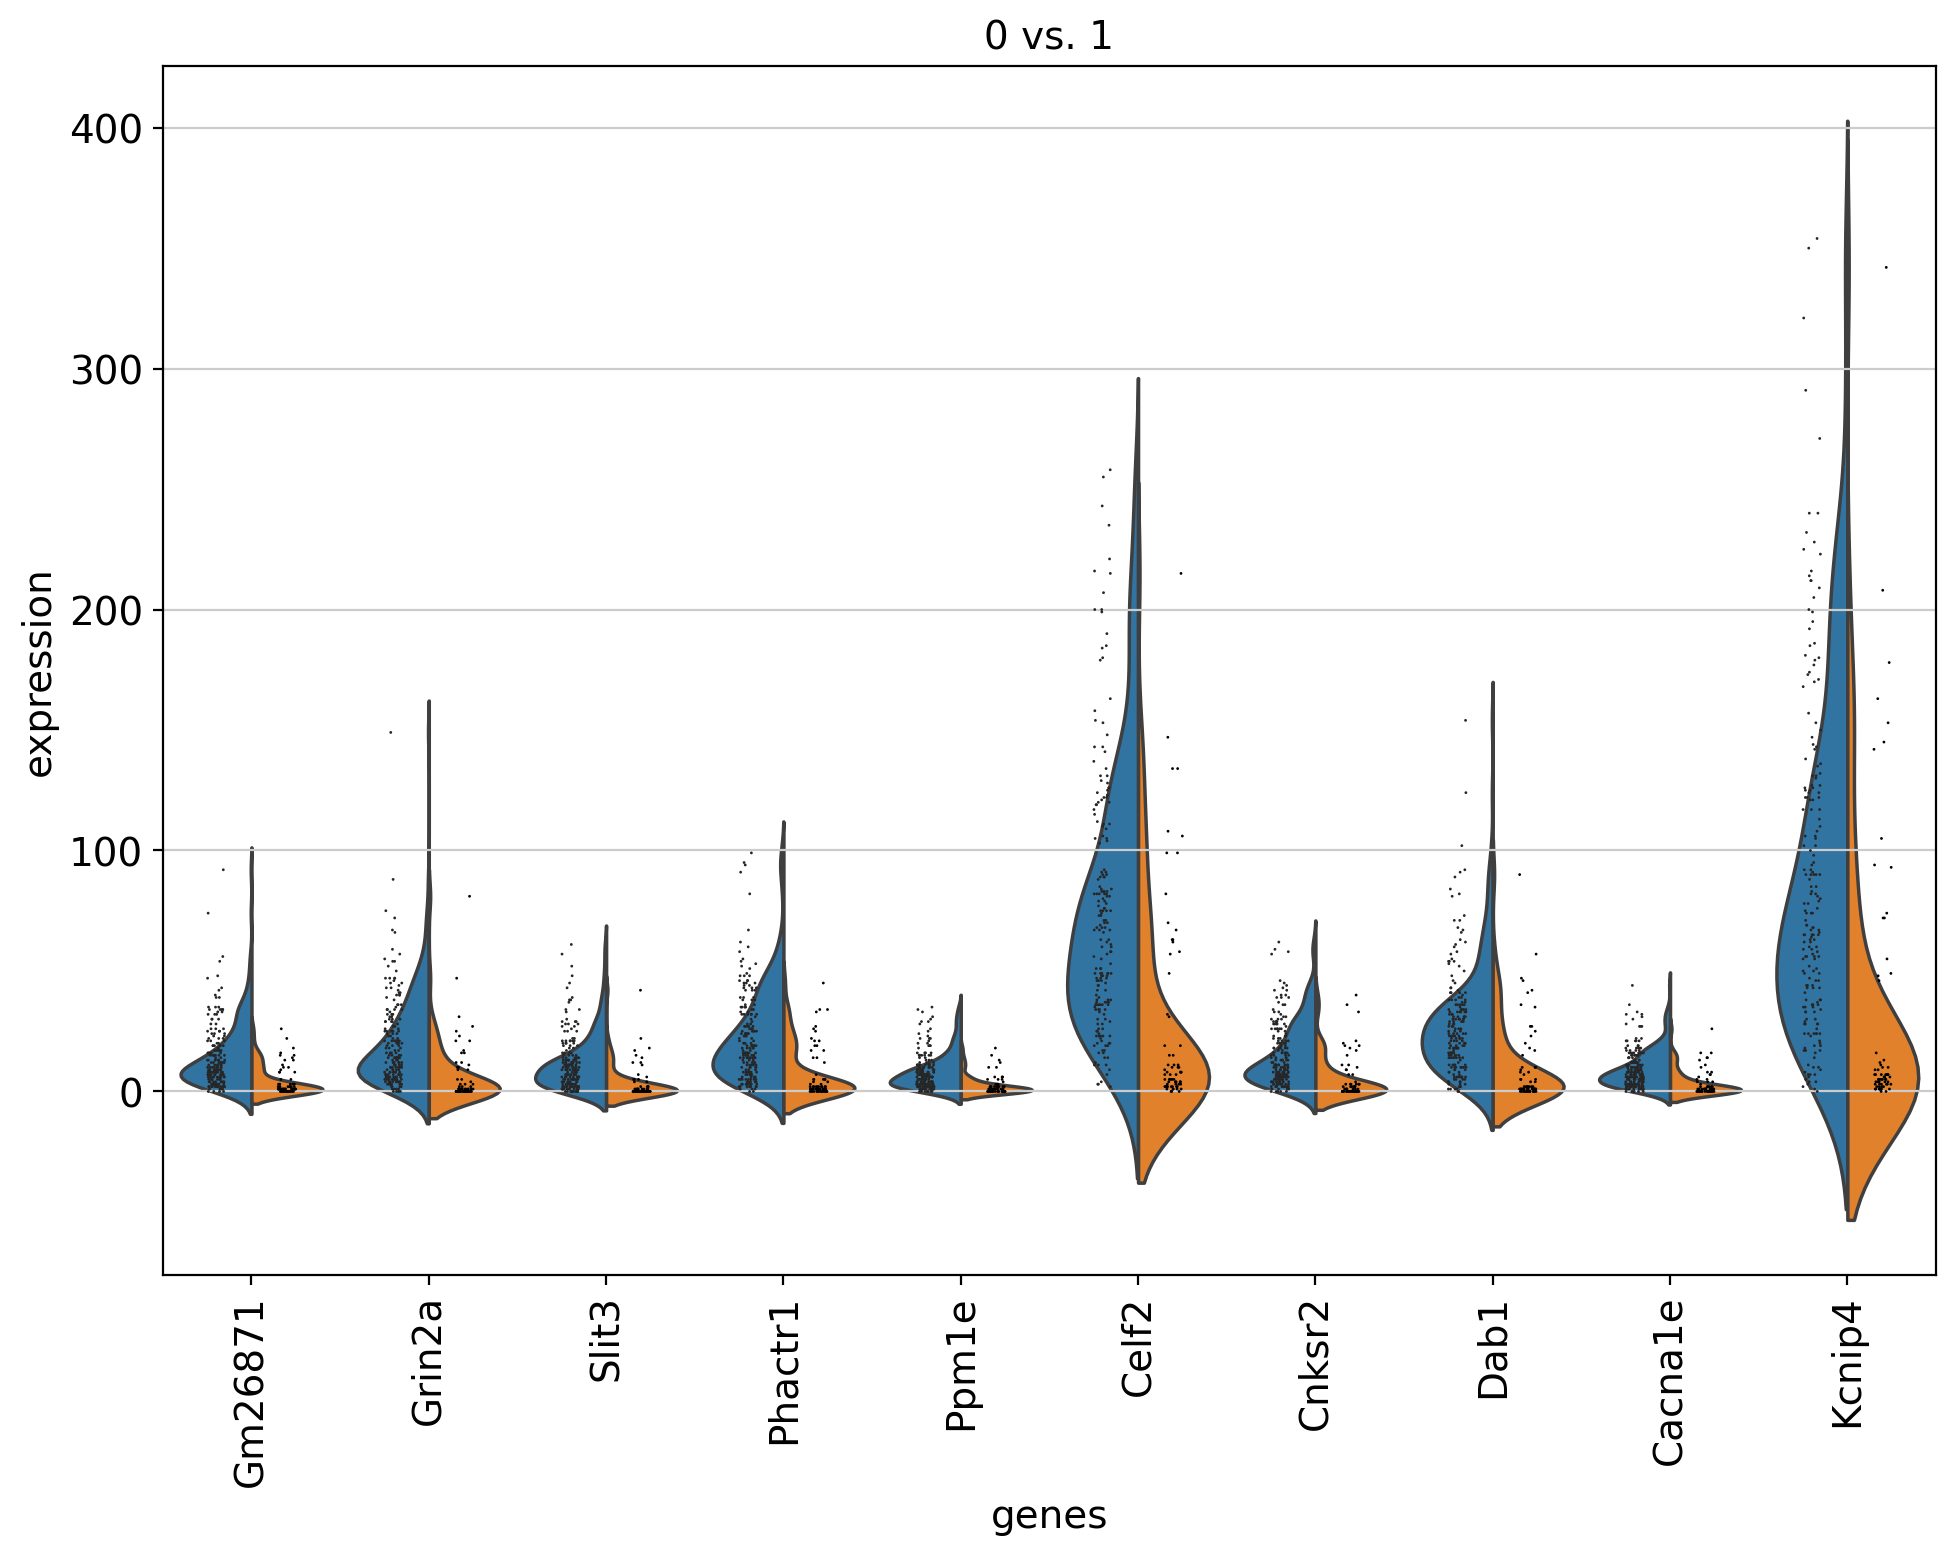

,names,scores,logfoldchanges,pvals,pvals_adj
0,Gm26871,8.170509,15.024591,3.070908e-16,2.586933e-12
1,Grin2a,8.060559,20.068991,7.594596e-16,5.118150e-12
2,Slit3,8.006486,12.483436,1.180325e-15,5.834066e-12
3,Phactr1,7.980350,22.452890,1.459183e-15,5.834066e-12
4,Ppm1e,7.974943,8.585885,1.524509e-15,5.834066e-12
5,Celf2,7.972239,70.033806,1.558244e-15,5.834066e-12
6,Cnksr2,7.910055,14.870990,2.572752e-15,8.669147e-12
7,Dab1,7.893833,26.782757,2.930444e-15,8.976750e-12
8,Cacna1e,7.877611,9.251230,3.337001e-15,9.295840e-12
9,Kcnip4,7.868598,81.859787,3.586358e-15,9.295840e-12


In [16]:
# Perform differential expression between two groups (e.g., clusters 0 and 1)
sc.tl.rank_genes_groups(adata_hvg, 'leiden', groups=['0'], reference='1', method='wilcoxon')

# Plot results
plt.figure(figsize=(10, 8))
sc.pl.rank_genes_groups_violin(adata_hvg, groups=['0'], n_genes=10, show=False)
plt.tight_layout()
plt.show()

# Get differential expression results as dataframe
de_genes = sc.get.rank_genes_groups_df(adata_hvg, group='0', key='rank_genes_groups')
de_genes.head(20)

# 10. Save Results

In [18]:
OUT_DIR = "post_analysis/results"
os.makedirs(os.path.join(OUT_DIR, SAMPLE), exist_ok=True)

# Save the processed object for future use
adata_hvg.write(os.path.join(OUT_DIR, SAMPLE, 'R26_Nestin_Mut_adult_processed.h5ad'))

# Save key results to CSV files
adata_hvg.obs.to_csv(os.path.join(OUT_DIR, SAMPLE, 'cell_metadata.csv'))
pd.DataFrame({'UMAP1': adata_hvg.obsm['X_umap'][:, 0], 
              'UMAP2': adata_hvg.obsm['X_umap'][:, 1], 
              'cluster': adata_hvg.obs['leiden'],
              'cell_type': adata_hvg.obs['cell_type']}).to_csv(os.path.join(OUT_DIR, SAMPLE, 'umap_coordinates.csv'), index=False)

# Generate summary report
summary = {
    'total_cells': adata_hvg.n_obs,
    'total_genes': adata_hvg.n_vars,
    'clusters': len(np.unique(adata_hvg.obs['leiden'])),
    'cell_types': len(np.unique(adata_hvg.obs['cell_type'])),
    'cells_per_cluster': adata_hvg.obs['leiden'].value_counts().to_dict(),
    'cells_per_cell_type': adata_hvg.obs['cell_type'].value_counts().to_dict()
}

with open(os.path.join(OUT_DIR, SAMPLE, 'analysis_summary.txt'), 'w') as f:
    for key, value in summary.items():
        f.write(f"{key}: {value}\n")